In [1]:
# Data taken from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from datetime import datetime, timedelta
from ipywidgets import interact
import itertools
from tabulate import tabulate

# This is not recommended but I am doing this to suppress warnings from SARIMAX
warnings.simplefilter('ignore')

dataDir = os.path.join('data', 'JHU', '03_23_2020_1939hours')
# dataDir = '03_21_2020_2219hours'

# These are old files
# confirmedFilename = 'time_series_19-covid-Confirmed.csv'
# deathsFilename = 'time_series_19-covid-Deaths.csv'
# recoveredFilename = 'time_series_19-covid-Recovered.csv'

# Recovered is no longer available from 03/23/2020
confirmedFilename = 'time_series_covid19_confirmed_global.csv'
deathsFilename = 'time_series_covid19_deaths_global.csv'

# Countries to ski prediction
skipPredictionCountriesList = ['China', 'Korea, South', 'Singapore', 'Taiwan*']

In [16]:
# Load all 3 csv files
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(os.path.join(dataDir, confirmedFilename))
covidFrDict['deaths'] = pd.read_csv(os.path.join(dataDir, deathsFilename))
# Recovered is no longer available from 03/23/2020
# covidFrDict['recovered'] = pd.read_csv(os.path.join(dataDir, recoveredFilename))
covidFrDict['confirmed']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,11,16,21,22,22,22,24,24,40,40
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,38,42,51,55,59,64,70,76,89,104
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,37,48,54,60,74,87,90,139,201,230
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1,1,2,39,39,53,75,88,113,133
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,NaN,Grenada,12.116500,-61.679000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
234,NaN,Mozambique,-18.665695,35.529562,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
235,NaN,Syria,34.802075,38.996815,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
236,NaN,Timor-Leste,-8.874217,125.727539,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [17]:
# Get list of dates
colNamesList = list(covidFrDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName] # Dates always have '/20' in them

# Create list of datetime objects from date strings
dateTimeOjectList = [datetime.strptime(timeStr, '%m/%d/%y') for timeStr in dateList]

# Plot data of one country (no predictions)

In [18]:
# Function to get all three frames for a given country
def getCountryCovidFrDict(countryName):
    countryCovidFrDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryCovidFrDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryCovidFrDict

# Function for plotting country data
def plotCountryData(countryName, logScale=False):
    countryCovidFrDict = getCountryCovidFrDict(countryName)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    for key in countryCovidFrDict.keys():
        casesByDateDict = dict(countryCovidFrDict[key][dateList].sum(axis=0))
        # Stop drawing vertical lines on log scale when plotting zero
        if logScale:
            for dateKey in casesByDateDict.keys():
                if casesByDateDict[dateKey] == 0:
                    casesByDateDict[dateKey] = np.nan
        ax.plot(list(casesByDateDict.keys()), list(casesByDateDict.values()), marker='o', label=key);

    plt.xticks(rotation=45, ha="right");
    
    if logScale:
        plt.yscale('log')

    every_nth = 4
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left');
    plt.title('Data for {}'.format(countryName), fontsize=26);
    plt.xlabel('Date', fontsize=18);
    plt.ylabel('Number of cases', fontsize=18);

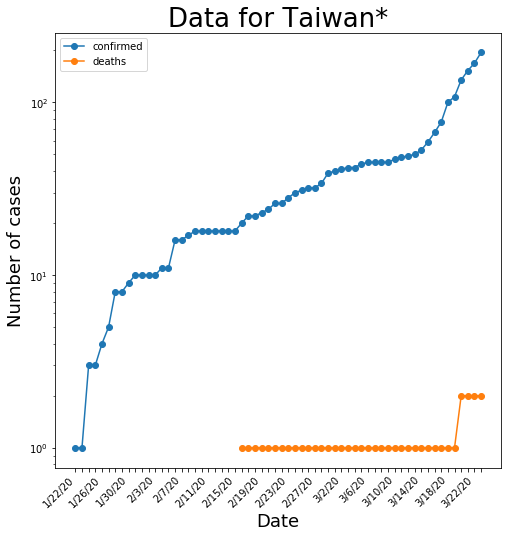

In [19]:
# Use logScale=True to plot in log scale on the y axis
plotCountryData('Taiwan*', logScale=True)


# Plot data with predictions for next n days

In [20]:
def getPredictionsForFuture(countryName,
                            nDays=5,
                            invertible=False, # Whether model is invertible or not
                            plot=True,
                            logScale=False,
                            grid=None,
                            printResults=True,
                            tablesToUse='all',
                            returnResults=False):
    '''
    tablesToUse is either 'all' for all tables, otherwise use a list containing one or more of 'confirmed', 'recovered' or 'deaths'
    '''
    
    # Extract model parameters
    p, d, q = (1, 2, 2)
    countryCovidFrDict = getCountryCovidFrDict(countryName)
    plotStartedFlag = False
    if tablesToUse == 'all':
        keysList = countryCovidFrDict.keys()
    else:
        keysList = tablesToUse
    allData = {}
    predData = {}
    for key in keysList:
        if printResults:
            print('Table type:', key)
        data = list(countryCovidFrDict[key][dateList].sum(axis=0))
        predictionsList = []

        for i in range(nDays):
            if invertible:
                model = SARIMAX(data, order=(p, d, q))

                model_fit = model.fit(disp=False)

                # make prediction
                yhat = model_fit.predict(len(data), len(data), typ='levels')
            else:
                model = SARIMAX(data, order=(p, d, q), enforce_invertibility=False)

                model_fit = model.fit(disp=False)

                # make prediction
                yhat = model_fit.predict(len(data), len(data), typ='levels')

            data.extend(yhat)
            predictionsList.append(yhat[0])
            
        # Required for printing as well as plotting
        dateTimeOjectForPlotList = dateTimeOjectList.copy()
        lastDateTimeObject = dateTimeOjectForPlotList[-1]
        futureDateTimeObjectList = []
        for i in range(nDays):
            lastDateTimeObject += timedelta(days=1)
            dateTimeOjectForPlotList.append(lastDateTimeObject)
            futureDateTimeObjectList.append(lastDateTimeObject)

        datetimeForPlotList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in dateTimeOjectForPlotList]
        futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]
        
        if printResults:
            print('Predictions for next {} days:'.format(nDays))
            # Round off predictions for printing
            predPrintList = [np.around(elem) for elem in predictionsList]
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
            print(tabulate(datePredList, headers=['Date', 'Prediction'], tablefmt='orgtbl'))
            
                
        if plot:
            # Start a plot if not already started
            if plotStartedFlag == False:
                fig = plt.figure(figsize=(8,8))
                ax = fig.add_subplot(111)
                plotStartedFlag = True
            if logScale:
                for i in range(len(data)):
                    if data[i] == 0:
                        data[i] = np.nan
            ax.plot(datetimeForPlotList, data, marker='o', label=key);
            # Circle predictions
            ax.scatter(futureDateTimeList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
        allDataDict = dict(zip(datetimeForPlotList, data))
        allData[key] = allDataDict

        predDict = dict(zip(futureDateTimeList, predictionsList))
        predData[key] = predDict
    if plot:
        if logScale:
            plt.yscale('log')
        plt.xticks(rotation=45, ha="right");
        
        every_nth = 4
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
        ax.legend(loc='upper left', prop={'size': 18});
        plt.title('Data for {}\n(Including predictions for next {} days)'.format(countryName, nDays), fontsize=24);
        plt.xlabel('Date', fontsize=18);
        if logScale:
            plt.ylabel('Number of cases (log scale)', fontsize=18);
        else:
            plt.ylabel('Number of cases', fontsize=18);
        
        if grid != None:
            plt.grid(axis=grid)
        
    if returnResults:
        return allData, predData

Table type: confirmed
Predictions for next 5 days:
| Date     |   Prediction |
|----------+--------------|
| 03/24/20 |          587 |
| 03/25/20 |          682 |
| 03/26/20 |          777 |
| 03/27/20 |          873 |
| 03/28/20 |          968 |


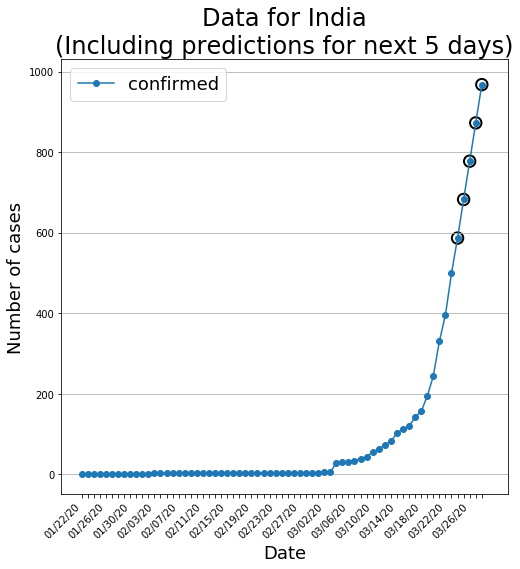

In [21]:
allData, predData = getPredictionsForFuture('India', 
                                            invertible=False,
                                            plot=True,
                                            logScale=False, 
                                            printResults=True, 
                                            nDays=5, 
                                            tablesToUse=['confirmed'], 
                                            grid='y',
                                            returnResults=True)

# Interactive plot to select country and other parameters

In [22]:
# Sort the list of countries for easier navigation
countryList = covidFrDict['confirmed']['Country/Region'].unique()
countryList.sort()

# Generate a possible list of all combinations of tables
keysList = list(covidFrDict.keys())
tablesToUseList = []
for i in range(1,len(keysList)+1):
    tablesList = list(itertools.combinations(['confirmed', 'deaths', 'recovered'], i)) # This gives a tuple
    # Convert tuple to list
    tablesList = [list(tablesTuple) for tablesTuple in tablesList]
    # Extend this list
    tablesToUseList.extend(tablesList)

In [23]:
# Wrapper function to ignore certain parameters (such as returnResults and plot) in display
def getPredictionsForFutureWrapper(countryName,
                                   nDays=5,
                                   invertible=False, # Whether model is invertible or not
                                   logScale=False,
                                   printResults=True,
                                   tablesToUse='all'):
    getPredictionsForFuture(countryName,
                            nDays=nDays,
                            invertible=invertible, # Whether model is invertible or not
                            logScale=logScale,
                            grid='y',
                            printResults=printResults,
                            tablesToUse=tablesToUse)
interact(getPredictionsForFutureWrapper,
         countryName=countryList,
         printResults=False,
         plot=True,
         grid='y',
         ndays=list(range(11)),
         invertible=False,
         tablesToUse=tablesToUseList,
         logScale=False,
         returnResults=False);

interactive(children=(Dropdown(description='countryName', options=('Afghanistan', 'Albania', 'Algeria', 'Andor…

# Compare plots of two countries

In [24]:
def comparePlotsOfNCountries(countryNameList,
                             nDays=5,
                             invertible=False, # Whether model is invertible or not
                             logScale=False,
                             grid=None,
                             printResults=True,
                             tableToUse='confirmed'):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    printListCreatedFlag = False
    for countryName in countryNameList:
        allData, predData = getPredictionsForFuture(countryName,
                                                    nDays=nDays,
                                                    invertible=invertible,
                                                    plot=False,
                                                    logScale=logScale,
                                                    grid=grid,
                                                    printResults=False,
                                                    tablesToUse=[tableToUse],
                                                    returnResults=True)
        allData = allData[tableToUse]
        predData = predData[tableToUse]
        ax.plot(list(allData.keys()), list(allData.values()), marker='o', label=countryName);
        
        if printListCreatedFlag == False:
            printListCreatedFlag = True
            
            futureDateTimeList = list(predData.keys())
            predictionsList = list(predData.values())
            predPrintList = [np.around(elem) for elem in predictionsList]
            
            # Zip dates and predictions together
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
        else:
            predictionsList = list(predData.values())
            for i in range(len(datePredList)):
                datePredList[i].append(np.around(predictionsList[i]))
                
        # Circle predictions
        ax.scatter(futureDateTimeList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
            
    if printResults:
        headerList = ['Date']
        headerList.extend(countryNameList)
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
            
        
    plt.xticks(rotation=45, ha="right");
    if logScale:
        plt.yscale('log')
        
    every_nth = 4
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left', prop={'size': 18});
    
    plt.title('Data\n(Including predictions for next {} days)'.format(nDays), fontsize=24);
    plt.xlabel('Date', fontsize=18);
    if logScale:
        plt.ylabel('Number of cases (log scale)', fontsize=18);
    else:
        plt.ylabel('Number of cases', fontsize=18);
        
    if grid != None:
        plt.grid(axis=grid)

| Date     |     US |   Italy |   India |   Spain |   China |
|----------+--------+---------+---------+---------+---------|
| 03/24/20 |  55663 |   69103 |     587 |   40239 |   81561 |
| 03/25/20 |  69241 |   74116 |     682 |   46040 |   81633 |
| 03/26/20 |  84578 |   79238 |     777 |   52037 |   81702 |
| 03/27/20 | 101676 |   84287 |     873 |   58088 |   81772 |
| 03/28/20 | 120533 |   89385 |     968 |   64155 |   81841 |


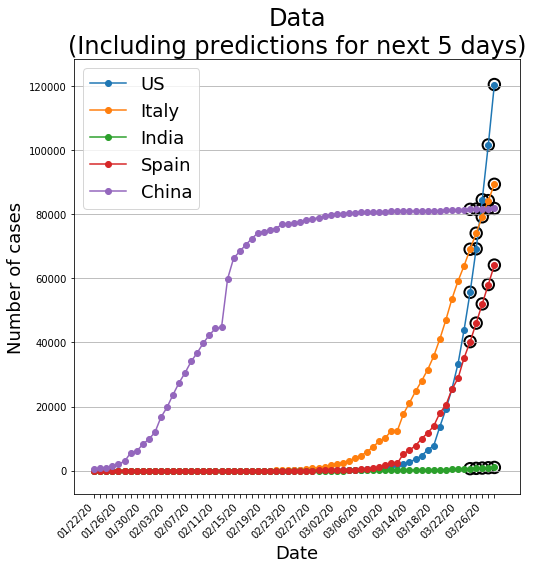

In [25]:
comparePlotsOfNCountries(['US', 'Italy', 'India', 'Spain', 'China'], nDays=5, grid='y')

In [26]:
# Interactive plot to compare data from 2 countries
def comparePlotsOf2CountriesWrapper(countryName1,
                                    countryName2,
                                    nDays=5,
                                    invertible=True, # Whether model is invertible or not
                                    logScale=False,
                                    printResults=True,
                                    tableToUse='confirmed'):
    
    countryNameList = [countryName1, countryName2]
    comparePlotsOfNCountries(countryNameList,
                             nDays=nDays,
                             invertible=invertible, # Whether model is invertible or not
                             logScale=logScale,
                             grid='y',
                             printResults=printResults,
                             tableToUse=tableToUse)
    plt.title('Data for {} and {}\n(Including predictions for next {} days)'.format(countryName1,
                                                                                    countryName2,
                                                                                    nDays),
              fontsize=24)
    
interact(comparePlotsOf2CountriesWrapper,
         countryName1=countryList,
         countryName2=countryList,
         printResults=True,
         ndays=list(range(11)),
         invertible=False,
         tableToUse=keysList,
         logScale=False);

interactive(children=(Dropdown(description='countryName1', options=('Afghanistan', 'Albania', 'Algeria', 'Ando…

# Plot of confirmed cases vs. days since nth case

| Date     |   Italy |     US |   Germany |   Spain |
|----------+---------+--------+-----------+---------|
| 03/24/20 |   69104 |  55571 |     32567 |   39953 |
| 03/25/20 |   74117 |  69046 |     36177 |   45588 |
| 03/26/20 |   79240 |  84265 |     39710 |   51349 |
| 03/27/20 |   84290 | 101226 |     43302 |   57129 |
| 03/28/20 |   89388 | 119926 |     46848 |   62910 |


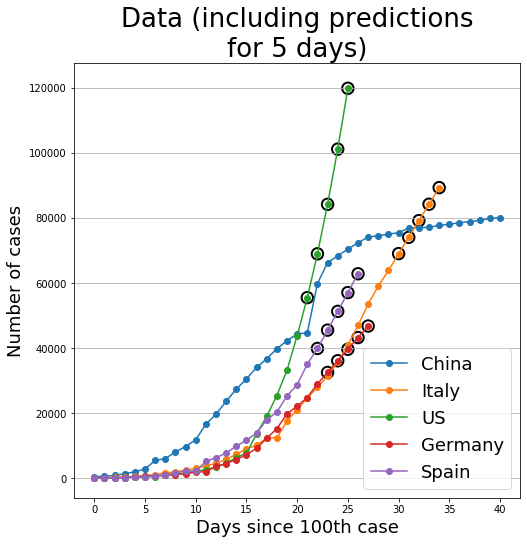

In [27]:
# Skip predictions for some countries right now
def comparePlotDaysSinceNCases(countryNamesList,
                               logScale=False,
                               daysSince=100,
                               nDaysPrediction=5,
                               invertible=False,
                               timeSeriesLim = 40, # Limit size of data to 40 points only
                               printResults=True): 
    # Extract model parameters
    p, d, q = (1, 2, 2)
    plotStartedFlag = False
    printListCreatedFlag = False
    for countryName in countryNamesList:
        allData, predData = getPredictionsForFuture(countryName,
                                                    nDays=0,
                                                    invertible=False, # Whether model is invertible or not
                                                    plot=False,
                                                    logScale=False,
                                                    grid=None,
                                                    printResults=False,
                                                    tablesToUse=['confirmed'],
                                                    returnResults=True)
        countryConfirmedFr =  allData['confirmed']
        
        nCasesGreaterDaysSinceList = []
        datesGreaterDaysSinceList = []
        for key in countryConfirmedFr.keys():
            if countryConfirmedFr[key] > daysSince:
                datesGreaterDaysSinceList.append(key)
                nCasesGreaterDaysSinceList.append(countryConfirmedFr[key])
                
        lastDateAvailable = datesGreaterDaysSinceList[-1]
        lastDateAvailableDateTimeObject = datetime.strptime(lastDateAvailable, '%m/%d/%y')
                
        data = nCasesGreaterDaysSinceList
        if len(data) > timeSeriesLim:
            data = data[:timeSeriesLim+1]
        predictionsList = []
        predictionPointsXCoordinateList = list(range(len(data), len(data)+nDaysPrediction))

        if countryName not in skipPredictionCountriesList:
            for i in range(nDaysPrediction):
                model = SARIMAX(data, order=(p, d, q), enforce_invertibility=invertible)

                model_fit = model.fit(disp=False)

                # make prediction
                yhat = model_fit.predict(len(data), len(data), typ='levels')

                data.extend(yhat)
                predictionsList.append(yhat[0])
            
            if printListCreatedFlag == False:
                printListCreatedFlag = True
                
                futureDateTimeObjectList = []
                for i in range(nDaysPrediction):
                    lastDateAvailableDateTimeObject += timedelta(days=1)
                    futureDateTimeObjectList.append(lastDateAvailableDateTimeObject)
                futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]

                predPrintList = [np.around(elem) for elem in predictionsList]

                # Zip dates and predictions together
                datePredList = list(zip(futureDateTimeList, predPrintList))
                # Convert individual elements of zip to a list
                datePredList = [list(elem) for elem in datePredList]
            else:
                for i in range(len(datePredList)):
                    datePredList[i].append(np.around(predictionsList[i]))
        
        if plotStartedFlag == False:
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            plotStartedFlag = True
        if logScale:
            for i in range(len(data)):
                if data[i] == 0:
                    data[i] = np.nan
        ax.plot(data, marker='o', label=countryName);
        if countryName not in skipPredictionCountriesList:
            # Circle predictions
            ax.scatter(predictionPointsXCoordinateList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
    if printResults:
        
        headerList = ['Date']
        for countryName in countryNamesList:
            if countryName not in skipPredictionCountriesList:
                headerList.append(countryName)
                
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
        
    ax.legend(loc='lower right', prop={'size': 18});
#     plt.title('Data for {}'.format(countryName), fontsize=26);
    plt.title('Data (including predictions\nfor {} days)'.format(nDaysPrediction), fontsize=26);
    plt.xlabel('Days since {}th case'.format(daysSince), fontsize=18);
    plt.ylabel('Number of cases', fontsize=18);
    plt.grid(axis='y')
        
comparePlotDaysSinceNCases(['China', 'Italy', 'US', 'Germany', 'Spain'], daysSince=100)

# Plot of new cases per day since n= 100th case

| Date     |    US |   Italy |
|----------+-------+---------|
| 03/24/20 | 11877 |    7037 |
| 03/25/20 | 13653 |    7064 |
| 03/26/20 | 15455 |    7330 |
| 03/27/20 | 17252 |    7454 |
| 03/28/20 | 19043 |    7811 |


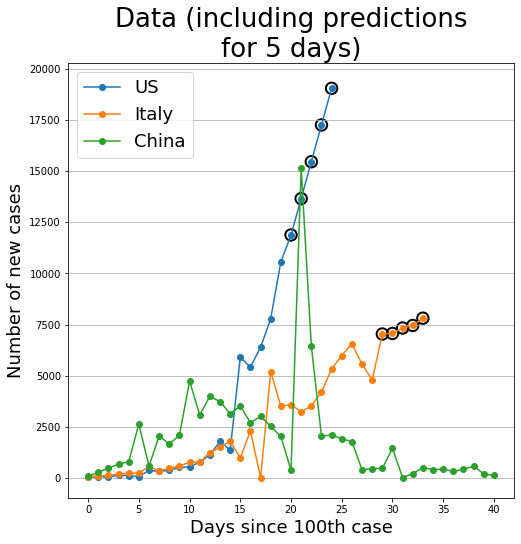

In [28]:
def comparePlotDaysSinceNCases_showNewCasesPerDay(countryNamesList,
                                                  logScale=False,
                                                  daysSince=100,
                                                  invertible=False,
                                                  nDaysPrediction=5,
                                                  timeSeriesLim = 40, # Limit size of data to 40 points only
                                                  printResults=True):
    p, d, q = (1, 2, 2)
    plotStartedFlag = False
    printListCreatedFlag = False
    for countryName in countryNamesList:
        allData, predData = getPredictionsForFuture(countryName,
                                                    nDays=0,
                                                    invertible=False, # Whether model is invertible or not
                                                    plot=False,
                                                    logScale=False,
                                                    grid=None,
                                                    printResults=False,
                                                    tablesToUse=['confirmed'],
                                                    returnResults=True)
        countryConfirmedFr =  allData['confirmed']
        
        nCasesGreaterDaysSinceList = []
        datesGreaterDaysSinceList = []
        for key in countryConfirmedFr.keys():
            if countryConfirmedFr[key] > daysSince:
                datesGreaterDaysSinceList.append(key)
                nCasesGreaterDaysSinceList.append(countryConfirmedFr[key])
                
        casesPerDayList = [t - s for s, t in zip(nCasesGreaterDaysSinceList, nCasesGreaterDaysSinceList[1:])]
        
        lastDateAvailable = datesGreaterDaysSinceList[-1]
        lastDateAvailableDateTimeObject = datetime.strptime(lastDateAvailable, '%m/%d/%y')
        
        data = casesPerDayList
        if len(data) > timeSeriesLim:
            data = data[:timeSeriesLim+1]
        predictionsList = []
        predictionPointsXCoordinateList = list(range(len(data), len(data)+nDaysPrediction))

        if countryName not in skipPredictionCountriesList:
            for i in range(nDaysPrediction):
                model = SARIMAX(data, order=(p, d, q), enforce_invertibility=invertible)

                model_fit = model.fit(disp=False)

                # make prediction
                yhat = model_fit.predict(len(data), len(data), typ='levels')

                data.extend(yhat)
                predictionsList.append(yhat[0])
                
            if printListCreatedFlag == False:
                printListCreatedFlag = True
                
                futureDateTimeObjectList = []
                for i in range(nDaysPrediction):
                    lastDateAvailableDateTimeObject += timedelta(days=1)
                    futureDateTimeObjectList.append(lastDateAvailableDateTimeObject)
                futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]

                predPrintList = [np.around(elem) for elem in predictionsList]

                # Zip dates and predictions together
                datePredList = list(zip(futureDateTimeList, predPrintList))
                # Convert individual elements of zip to a list
                datePredList = [list(elem) for elem in datePredList]
            else:
                for i in range(len(datePredList)):
                    datePredList[i].append(np.around(predictionsList[i]))
        
        if plotStartedFlag == False:
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            plotStartedFlag = True
        if logScale:
            for i in range(len(data)):
                if data[i] == 0:
                    data[i] = np.nan
        ax.plot(data, marker='o', label=countryName);
        
        if countryName not in skipPredictionCountriesList:
            # Circle predictions
            ax.scatter(predictionPointsXCoordinateList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
    if printResults:
        
        headerList = ['Date']
        for countryName in countryNamesList:
            if countryName not in skipPredictionCountriesList:
                headerList.append(countryName)
                
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
        
    ax.legend(loc='upper left', prop={'size': 18});
#     plt.title('Data for {}'.format(countryName), fontsize=26);
    plt.title('Data (including predictions\nfor {} days)'.format(nDaysPrediction), fontsize=26);
    plt.xlabel('Days since {}th case'.format(daysSince), fontsize=18);
    plt.ylabel('Number of new cases', fontsize=18);
    plt.grid(axis='y')
        
comparePlotDaysSinceNCases_showNewCasesPerDay(['US', 'Italy', 'China'], daysSince=100)

# Rate of change of number of cases per day

| Date     |   US |
|----------+------|
| 03/24/20 | 1872 |
| 03/25/20 | 2688 |
| 03/26/20 | 2753 |
| 03/27/20 | 3150 |
| 03/28/20 | 3403 |


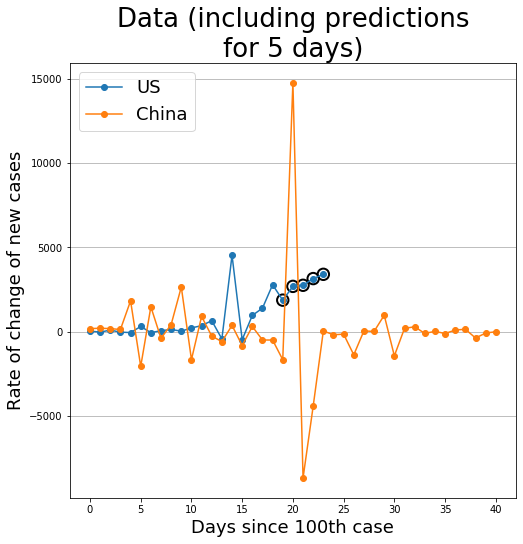

In [29]:
def comparePlotDaysSinceNCases_showRateOfChangeOfNewCasesPerDay(countryNamesList,
                                                  logScale=False,
                                                  daysSince=100,
                                                  invertible=False,
                                                  nDaysPrediction=5,
                                                  timeSeriesLim = 40, # Limit size of data to 40 points only
                                                  printResults=True):
    p, d, q = (1, 2, 2)
    plotStartedFlag = False
    printListCreatedFlag = False
    for countryName in countryNamesList:
        allData, predData = getPredictionsForFuture(countryName,
                                                    nDays=0,
                                                    invertible=False, # Whether model is invertible or not
                                                    plot=False,
                                                    logScale=False,
                                                    grid=None,
                                                    printResults=False,
                                                    tablesToUse=['confirmed'],
                                                    returnResults=True)
        countryConfirmedFr =  allData['confirmed']
        
        nCasesGreaterDaysSinceList = []
        datesGreaterDaysSinceList = []
        for key in countryConfirmedFr.keys():
            if countryConfirmedFr[key] > daysSince:
                datesGreaterDaysSinceList.append(key)
                nCasesGreaterDaysSinceList.append(countryConfirmedFr[key])
                
        casesPerDayList = [t - s for s, t in zip(nCasesGreaterDaysSinceList, nCasesGreaterDaysSinceList[1:])]
        rateOfChangeOfCasesPerDayList = [t - s for s, t in zip(casesPerDayList, casesPerDayList[1:])]
        
        lastDateAvailable = datesGreaterDaysSinceList[-1]
        lastDateAvailableDateTimeObject = datetime.strptime(lastDateAvailable, '%m/%d/%y')
        
        data = rateOfChangeOfCasesPerDayList
        if len(data) > timeSeriesLim:
            data = data[:timeSeriesLim+1]
        predictionsList = []
        predictionPointsXCoordinateList = list(range(len(data), len(data)+nDaysPrediction))

        if countryName not in skipPredictionCountriesList:
            for i in range(nDaysPrediction):
                model = SARIMAX(data, order=(p, d, q), enforce_invertibility=invertible)

                model_fit = model.fit(disp=False)

                # make prediction
                yhat = model_fit.predict(len(data), len(data), typ='levels')

                data.extend(yhat)
                predictionsList.append(yhat[0])
                
            if printListCreatedFlag == False:
                printListCreatedFlag = True
                
                futureDateTimeObjectList = []
                for i in range(nDaysPrediction):
                    lastDateAvailableDateTimeObject += timedelta(days=1)
                    futureDateTimeObjectList.append(lastDateAvailableDateTimeObject)
                futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]

                predPrintList = [np.around(elem) for elem in predictionsList]

                # Zip dates and predictions together
                datePredList = list(zip(futureDateTimeList, predPrintList))
                # Convert individual elements of zip to a list
                datePredList = [list(elem) for elem in datePredList]
            else:
                for i in range(len(datePredList)):
                    datePredList[i].append(np.around(predictionsList[i]))
        
        if plotStartedFlag == False:
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            plotStartedFlag = True
        if logScale:
            for i in range(len(data)):
                if data[i] == 0:
                    data[i] = np.nan
        ax.plot(data, marker='o', label=countryName);
        
        if countryName not in skipPredictionCountriesList:
            # Circle predictions
            ax.scatter(predictionPointsXCoordinateList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
    if printResults:
        
        headerList = ['Date']
        for countryName in countryNamesList:
            if countryName not in skipPredictionCountriesList:
                headerList.append(countryName)
                
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
        
    ax.legend(loc='upper left', prop={'size': 18});
#     plt.title('Data for {}'.format(countryName), fontsize=26);
    plt.title('Data (including predictions\nfor {} days)'.format(nDaysPrediction), fontsize=26);
    plt.xlabel('Days since {}th case'.format(daysSince), fontsize=18);
    plt.ylabel('Rate of change of new cases', fontsize=18);
    plt.grid(axis='y')
        
comparePlotDaysSinceNCases_showRateOfChangeOfNewCasesPerDay(['US', 'China'], daysSince=100, invertible=False)

# Predictions for states in the US using covidtracking.com data

In [46]:
USDataFilename = os.path.join('data', 'covidtracking', 'states-daily.csv')
USCovidFr = pd.read_csv(USDataFilename)
USCovidFr

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked
0,20200323,AK,22.0,946.0,NaN,0.0,NaN,968,2020-03-23T20:00:00Z
1,20200323,AL,167.0,1665.0,NaN,NaN,0.0,1832,2020-03-23T20:00:00Z
2,20200323,AR,174.0,906.0,0.0,13.0,0.0,1080,2020-03-23T20:00:00Z
3,20200323,AS,NaN,NaN,NaN,NaN,0.0,0,2020-03-23T20:00:00Z
4,20200323,AZ,265.0,309.0,6.0,NaN,2.0,580,2020-03-23T20:00:00Z
...,...,...,...,...,...,...,...,...,...
976,20200304,OR,3.0,29.0,18.0,NaN,NaN,50,2020-03-04T21:00:00Z
977,20200304,SC,0.0,5.0,0.0,NaN,NaN,5,2020-03-04T21:00:00Z
978,20200304,TX,1.0,NaN,NaN,NaN,NaN,1,2020-03-04T21:00:00Z
979,20200304,WA,39.0,NaN,NaN,NaN,NaN,39,2020-03-04T21:00:00Z


### Plot US State data

In [135]:
# Columns to use
colsList = ['positive', 'negative', 'hospitalized', 'death']

# Get dataframe for US State
def getUSStateCovidFr(USStateName):
    USStateCovidFr = USCovidFr[USCovidFr['state'] == USStateName]
    return USStateCovidFr

def convertDateToReadableFormat(dateList):
    dtObjectList = []
    for dateInt in dateList:
        dateStr = str(dateInt)
        x = datetime(int(dateStr[:4]), int(dateStr[4:6]), int(dateStr[6:8]))
        dtObjectList.append(x)
    dateTimeList = [dtObject.strftime('%m/%d/%y') for dtObject in dtObjectList]
    return dateTimeList, dtObjectList

# Function for plotting US state data
def plotUSStateData(USStateName, logScale=False, tablesToUse='all'):
    '''
    tablestoUse is either 'all' or a list of table names from colsList
    '''
    USStateCovidFr = getUSStateCovidFr(USStateName)
    dateList = USStateCovidFr['date'].tolist()
    readableDateList, _ = convertDateToReadableFormat(dateList)
    # Data is latest to oldest
    readableDateList.reverse()
    
    USStateCovidDataDict = {}
    for col in colsList:
        dataList = USStateCovidFr[col].tolist()
        dataList.reverse()
        USStateCovidDataDict[col] = dataList
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    if tablesToUse == 'all':
        for col in colsList:
            ax.plot(readableDateList, USStateCovidDataDict[col], marker='o', label=col);
    else:
        for tableToUse in tablesToUse:
            ax.plot(readableDateList, USStateCovidDataDict[tableToUse], marker='o', label=tableToUse);

    plt.xticks(rotation=45, ha="right");
    
    if logScale:
        plt.yscale('log')

    every_nth = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left');
    plt.title('Data for {}'.format(USStateName), fontsize=26);
    plt.xlabel('Date', fontsize=18);
    plt.ylabel('Number of cases', fontsize=18);
    plt.grid(axis='y')

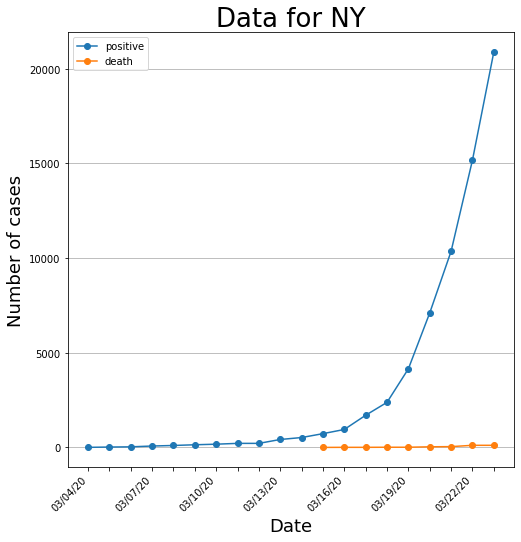

In [136]:
plotUSStateData('NY', tablesToUse=['positive', 'death'])

### Plot data with predictions for next n days

In [186]:
def getPredictionsForFuture_USState(USStateName,
                                    nDays=5,
                                    invertible=False, # Whether model is invertible or not
                                    plot=True,
                                    logScale=False,
                                    grid=None,
                                    printResults=True,
                                    tablesToUse='all',
                                    returnResults=False):
    '''
    tablesToUse is either 'all' for all tables, otherwise use a list containing one or more of 'confirmed', 'recovered' or 'deaths'
    '''
    
    # Extract model parameters
    p, d, q = (1, 2, 2)
    
    USStateCovidFr = getUSStateCovidFr(USStateName)
    dateList = USStateCovidFr['date'].tolist()
    readableDateList, dtObjectList = convertDateToReadableFormat(dateList)
    # Data is latest to oldest
    readableDateList.reverse()
    dtObjectList.reverse()
    
    USStateCovidDataDict = {}
    for col in colsList:
        dataList = USStateCovidFr[col].tolist()
        dataList.reverse()
        USStateCovidDataDict[col] = dataList
    
    plotStartedFlag = False
    if tablesToUse == 'all':
        keysList = USStateCovidFr.keys()
    else:
        keysList = tablesToUse
    allData = {}
    predData = {}
    for key in keysList:
        data = list(USStateCovidDataDict[key])
#         if len(data) == 0:
#             allDataDict = dict(zip(datetimeForPlotList, [0]*len(datetimeForPlotList)))
#             allData[key] = allDataDict
#             continue
            
        predictionsList = []

        for i in range(nDays):
            model = SARIMAX(data, order=(p, d, q), enforce_invertibility=invertible)

            model_fit = model.fit(disp=False)

            # make prediction
            yhat = model_fit.predict(len(data), len(data), typ='levels')

            data.extend(yhat)
            predictionsList.append(yhat[0])
            
        # Required for printing as well as plotting
        dateTimeOjectForPlotList = dtObjectList.copy()
        lastDateTimeObject = dateTimeOjectForPlotList[-1]
        futureDateTimeObjectList = []
        for i in range(nDays):
            lastDateTimeObject += timedelta(days=1)
            dateTimeOjectForPlotList.append(lastDateTimeObject)
            futureDateTimeObjectList.append(lastDateTimeObject)

        datetimeForPlotList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in dateTimeOjectForPlotList]
        futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]
        
        if printResults:
            print('Predictions for next {} days:'.format(nDays))
            # Round off predictions for printing
            predPrintList = [np.around(elem) for elem in predictionsList]
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
            print(tabulate(datePredList, headers=['Date', 'Prediction'], tablefmt='orgtbl'))
            
                
        if plot:
            # Start a plot if not already started
            if plotStartedFlag == False:
                fig = plt.figure(figsize=(8,8))
                ax = fig.add_subplot(111)
                plotStartedFlag = True
            if logScale:
                for i in range(len(data)):
                    if data[i] == 0:
                        data[i] = np.nan
            ax.plot(datetimeForPlotList, data, marker='o', label=key);
            # Circle predictions
            ax.scatter(futureDateTimeList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
        allDataDict = dict(zip(datetimeForPlotList, data))
        allData[key] = allDataDict

        predDict = dict(zip(futureDateTimeList, predictionsList))
        predData[key] = predDict
    if plot:
        if logScale:
            plt.yscale('log')
        plt.xticks(rotation=45, ha="right");
        
        every_nth = 4
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
        ax.legend(loc='upper left', prop={'size': 18});
        plt.title('Data for {}\n(Including predictions for next {} days)'.format(USStateName, nDays), fontsize=24);
        plt.xlabel('Date', fontsize=18);
        if logScale:
            plt.ylabel('Number of cases (log scale)', fontsize=18);
        else:
            plt.ylabel('Number of cases', fontsize=18);
        
        if grid != None:
            plt.grid(axis=grid)
        
    if returnResults:
        return allData, predData

Predictions for next 5 days:
| Date     |   Prediction |
|----------+--------------|
| 03/24/20 |        27649 |
| 03/25/20 |        35412 |
| 03/26/20 |        44166 |
| 03/27/20 |        53914 |
| 03/28/20 |        64621 |
{'positive': {'03/04/20': 6.0, '03/05/20': 22.0, '03/06/20': 33.0, '03/07/20': 76.0, '03/08/20': 105.0, '03/09/20': 142.0, '03/10/20': 173.0, '03/11/20': 216.0, '03/12/20': 216.0, '03/13/20': 421.0, '03/14/20': 524.0, '03/15/20': 729.0, '03/16/20': 950.0, '03/17/20': 1700.0, '03/18/20': 2382.0, '03/19/20': 4152.0, '03/20/20': 7102.0, '03/21/20': 10356.0, '03/22/20': 15168.0, '03/23/20': 20875.0, '03/24/20': 27649.214315400644, '03/25/20': 35412.202794491976, '03/26/20': 44165.54762831077, '03/27/20': 53913.81970490009, '03/28/20': 64621.099090046824}}


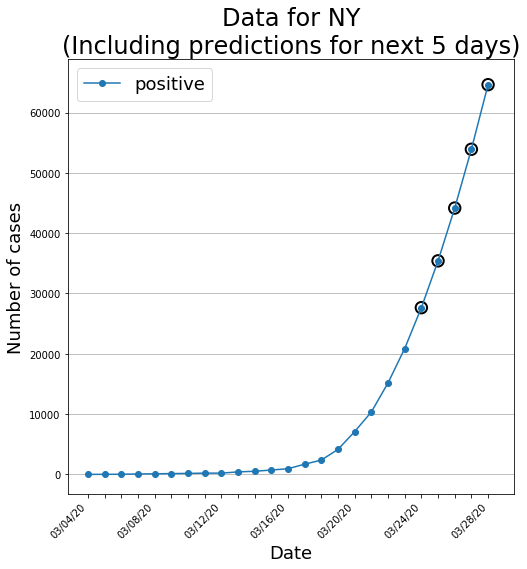

In [187]:
allData, predData = getPredictionsForFuture_USState('NY',
                                                    invertible=False,
                                                    plot=True,
                                                    logScale=False, 
                                                    printResults=True, 
                                                    nDays=5, 
                                                    tablesToUse=['positive'], 
                                                    grid='y',
                                                    returnResults=True)
print(allData)

### Interactive plot to select US state and other parameters

In [188]:
# Sort the list of US states for easier navigation
USStatesCorrectedList = USCovidFr['state'].unique()
USStatesCorrectedList.sort()

# Generate a possible list of all combinations of tables
keysList = list(USCovidFrDict.keys())
tablesToUseList = []
for i in range(1,len(keysList)+1):
    tablesList = list(itertools.combinations(['positive', 'negative', 'hospitalized', 'death'], i)) # This gives a tuple
    # Convert tuple to list
    tablesList = [list(tablesTuple) for tablesTuple in tablesList]
    # Extend this list
    tablesToUseList.extend(tablesList)

In [189]:
# Wrapper function to ignore certain parameters (such as returnResults and plot) in display
def getPredictionsForFuture_USStateWrapper(USStateName,
                                           nDays=5,
                                           invertible=False, # Whether model is invertible or not
                                           logScale=False,
                                           printResults=True,
                                           tablesToUse='all'):
    getPredictionsForFuture_USState(USStateName,
                                    nDays=nDays,
                                    invertible=invertible, # Whether model is invertible or not
                                    logScale=logScale,
                                    grid='y',
                                    printResults=printResults,
                                    tablesToUse=tablesToUse)
interact(getPredictionsForFuture_USStateWrapper,
         USStateName=USStatesCorrectedList,
         printResults=False,
         plot=True,
         grid='y',
         ndays=list(range(11)),
         invertible=False,
         tablesToUse=tablesToUseList,
         logScale=False,
         returnResults=False);

interactive(children=(Dropdown(description='USStateName', options=('AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', '…

### Compare plots of two or more states

In [190]:
def comparePlotsOfNUSStates(USStateNamesList,
                            nDays=5,
                            invertible=False, # Whether model is invertible or not
                            logScale=False,
                            grid=None,
                            printResults=True,
                            tableToUse='positive'):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    printListCreatedFlag = False
    for USStateName in USStateNamesList:
        allData, predData = getPredictionsForFuture_USState(USStateName,
                                                            nDays=nDays,
                                                            invertible=invertible,
                                                            plot=False,
                                                            logScale=logScale,
                                                            grid=grid,
                                                            printResults=False,
                                                            tablesToUse=[tableToUse],
                                                            returnResults=True)
        allData = allData[tableToUse]
        predData = predData[tableToUse]
        if logScale:
            for key in allData.keys():
                if allData[key] == 0:
                    allData[key] = np.nan
            
        ax.plot(list(allData.keys()), list(allData.values()), marker='o', label=USStateName);
        
        # Circle predictions
        ax.scatter(list(predData.keys()), list(predData.values()), s=130, linewidth=2, facecolors='none', edgecolors='k');
        
        if printListCreatedFlag == False:
            printListCreatedFlag = True
            
            futureDateTimeList = list(predData.keys())
            predictionsList = list(predData.values())
            predPrintList = [np.around(elem) for elem in predictionsList]
            
            # Zip dates and predictions together
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
        else:
            predictionsList = list(predData.values())
            for i in range(len(datePredList)):
                datePredList[i].append(np.around(predictionsList[i]))
            
    if printResults:
        headerList = ['Date']
        headerList.extend(USStateNamesList)
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
            
        
    plt.xticks(rotation=45, ha="right");
    if logScale:
        plt.yscale('log')
        
    every_nth = 4
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left', prop={'size': 18});
    
    plt.title('Data\n(Including predictions for next {} days)'.format(nDays), fontsize=24);
    plt.xlabel('Date', fontsize=18);
    if logScale:
        plt.ylabel('Number of cases (log scale)', fontsize=18);
    else:
        plt.ylabel('Number of cases', fontsize=18);
        
    if grid != None:
        plt.grid(axis=grid)

| Date     |   AZ |   AK |
|----------+------+------|
| 03/24/20 |  396 |   30 |
| 03/25/20 |  585 |   33 |
| 03/26/20 |  827 |   40 |
| 03/27/20 | 1118 |   43 |
| 03/28/20 | 1454 |   50 |


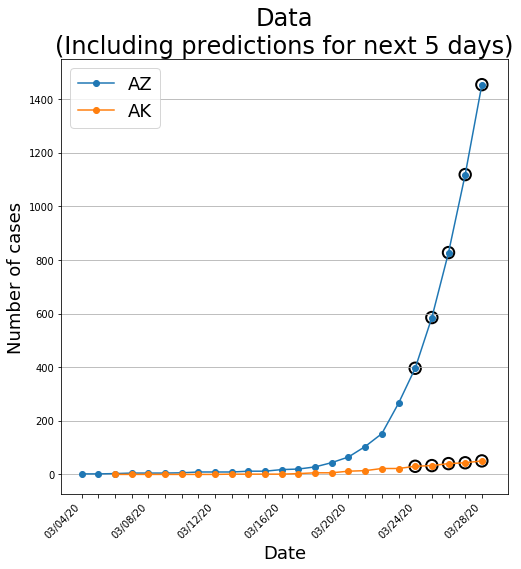

In [191]:
comparePlotsOfNUSStates(['AZ', 'AK'], nDays=5, grid='y', logScale=False)

In [193]:
# Interactive plot to compare data from 2 US states
def comparePlotsOf2USSTatesWrapper(USStateName1,
                                   USStateName2,
                                   nDays=5,
                                   invertible=True, # Whether model is invertible or not
                                   logScale=False,
                                   printResults=True,
                                   tableToUse='positive'):
    
    USStateNameList = [USStateName1, USStateName2]
    comparePlotsOfNUSStates(USStateNameList,
                            nDays=nDays,
                            invertible=invertible, # Whether model is invertible or not
                            logScale=logScale,
                            grid='y',
                            printResults=printResults,
                            tableToUse=tableToUse)
    plt.title('Data for {} and {}\n(Including predictions for next {} days)'.format(USStateName1,
                                                                                    USStateName2,
                                                                                    nDays),
              fontsize=24)
    
interact(comparePlotsOf2USSTatesWrapper,
         USStateName1=USStatesCorrectedList,
         USStateName2=USStatesCorrectedList,
         printResults=True,
         ndays=list(range(11)),
         invertible=False,
         tableToUse=colsList,
         logScale=False);

interactive(children=(Dropdown(description='USStateName1', options=('AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', …

### Plot of new cases per day since n = 100th case

| Date     |    NY |   CA |   WA |
|----------+-------+------+------|
| 03/24/20 |  6732 |  264 |  283 |
| 03/25/20 |  7722 |  256 |  253 |
| 03/26/20 |  8726 |  286 |  295 |
| 03/27/20 |  9739 |  296 |  296 |
| 03/28/20 | 10753 |  316 |  314 |


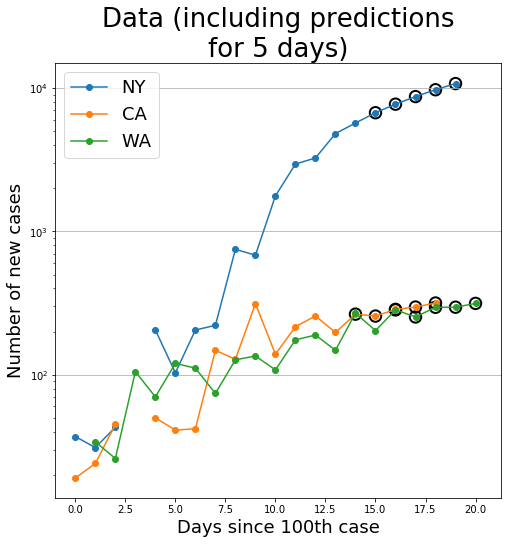

In [198]:
def comparePlotDaysSinceNCases_showNewCasesPerDay_USStates(USStateNamesList,
                                                           logScale=False,
                                                           daysSince=100,
                                                           invertible=False,
                                                           nDaysPrediction=5,
                                                           timeSeriesLim = 40, # Limit size of data to 40 points only
                                                           printResults=True):
    p, d, q = (1, 2, 2)
    plotStartedFlag = False
    printListCreatedFlag = False
    for USStateName in USStateNamesList:
        allData, predData = getPredictionsForFuture_USState(USStateName,
                                                            nDays=0,
                                                            invertible=False, # Whether model is invertible or not
                                                            plot=False,
                                                            logScale=False,
                                                            grid=None,
                                                            printResults=False,
                                                            tablesToUse=['positive'],
                                                            returnResults=True)
        USStateConfirmedFr =  allData['positive']
        
        nCasesGreaterDaysSinceList = []
        datesGreaterDaysSinceList = []
        for key in USStateConfirmedFr.keys():
            if USStateConfirmedFr[key] > daysSince:
                datesGreaterDaysSinceList.append(key)
                nCasesGreaterDaysSinceList.append(USStateConfirmedFr[key])
                
        casesPerDayList = [t - s for s, t in zip(nCasesGreaterDaysSinceList, nCasesGreaterDaysSinceList[1:])]
        
        lastDateAvailable = datesGreaterDaysSinceList[-1]
        lastDateAvailableDateTimeObject = datetime.strptime(lastDateAvailable, '%m/%d/%y')
        
        data = casesPerDayList
        if len(data) > timeSeriesLim:
            data = data[:timeSeriesLim+1]
        predictionsList = []
        predictionPointsXCoordinateList = list(range(len(data), len(data)+nDaysPrediction))

        for i in range(nDaysPrediction):
            model = SARIMAX(data, order=(p, d, q), enforce_invertibility=invertible)

            model_fit = model.fit(disp=False)

            # make prediction
            yhat = model_fit.predict(len(data), len(data), typ='levels')

            data.extend(yhat)
            predictionsList.append(yhat[0])

        if printListCreatedFlag == False:
            printListCreatedFlag = True

            futureDateTimeObjectList = []
            for i in range(nDaysPrediction):
                lastDateAvailableDateTimeObject += timedelta(days=1)
                futureDateTimeObjectList.append(lastDateAvailableDateTimeObject)
            futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]

            predPrintList = [np.around(elem) for elem in predictionsList]

            # Zip dates and predictions together
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
        else:
            for i in range(len(datePredList)):
                datePredList[i].append(np.around(predictionsList[i]))
        
        if plotStartedFlag == False:
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            plotStartedFlag = True
        if logScale:
            for i in range(len(data)):
                if data[i] == 0:
                    data[i] = np.nan
        ax.plot(data, marker='o', label=USStateName);
        

        # Circle predictions
        ax.scatter(predictionPointsXCoordinateList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
    if printResults:
        
        headerList = ['Date']
        for USStateName in USStateNamesList:
            headerList.append(USStateName)
                
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
        
    ax.legend(loc='upper left', prop={'size': 18});
#     plt.title('Data for {}'.format(countryName), fontsize=26);
    plt.title('Data (including predictions\nfor {} days)'.format(nDaysPrediction), fontsize=26);
    plt.xlabel('Days since {}th case'.format(daysSince), fontsize=18);
    plt.ylabel('Number of new cases', fontsize=18);
    plt.grid(axis='y')
    
    if logScale:
        plt.yscale('log')
        
comparePlotDaysSinceNCases_showNewCasesPerDay_USStates(['NY', 'CA', 'WA'], daysSince=100, logScale=True)

# Predictions for states in the US using JHU data (DEPRECATED)
# Statewise data is no longer available at the website since 03/23/2020

In [199]:
dataDir = os.path.join('data', 'JHU', '03_21_2020_2219hours')

confirmedFilename = 'time_series_19-covid-Confirmed.csv'
deathsFilename = 'time_series_19-covid-Deaths.csv'
recoveredFilename = 'time_series_19-covid-Recovered.csv'

# Load all 3 csv files
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(os.path.join(dataDir, confirmedFilename))
covidFrDict['deaths'] = pd.read_csv(os.path.join(dataDir, deathsFilename))
covidFrDict['recovered'] = pd.read_csv(os.path.join(dataDir, recoveredFilename))

# Get list of dates
colNamesList = list(covidFrDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName] # Dates always have '/20' in them

# Create list of datetime objects from date strings
dateTimeOjectList = [datetime.strptime(timeStr, '%m/%d/%y') for timeStr in dateList]


USCovidFrDict = getCountryCovidFrDict('US')
USCovidFrDict['confirmed']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,442,568,572,643,904,1076,1014,1376,1524,1793
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,328,421,525,732,967,1706,2495,5365,8310,11710
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,221,282,340,426,557,698,751,952,1177,1364
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,108,123,138,164,197,218,218,328,413,525
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,46,46,46,46,47,47,47,47,49,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
414,Alabama,US,32.3182,-86.9023,0,0,0,0,0,0,...,0,5,6,12,29,39,46,78,83,131
417,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,0,0,3,5,5,5,5,5,14,21
431,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,0,0,3,3,3,5,12,14,15


In [200]:
USStatesList = USCovidFrDict['confirmed']['Province/State'].tolist()
USStatesCorrectedList = [USState for USState in USStatesList if ',' not in USState]
print(len(USStatesCorrectedList))

56


### Plot US State data

In [201]:
# Get dataframe for US State
def getUSStateCovidFr(USStateName):
    USStateCovidFrDict = {}
    for key in USCovidFrDict.keys():
        dataFr = USCovidFrDict[key]
        USStateCovidFrDict[key] = dataFr[dataFr['Province/State'] == USStateName]
    return USStateCovidFrDict

# Function for plotting US state data
def plotUSStateData(USStateName, logScale=False):
    USStateCovidFrDict = getUSStateCovidFr(USStateName)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    for key in USStateCovidFrDict.keys():
        casesByDateDict = dict(USStateCovidFrDict[key][dateList].sum(axis=0))
        # Stop drawing vertical lines on log scale when plotting zero
        if logScale:
            for dateKey in casesByDateDict.keys():
                if casesByDateDict[dateKey] == 0:
                    casesByDateDict[dateKey] = np.nan
        ax.plot(list(casesByDateDict.keys()), list(casesByDateDict.values()), marker='o', label=key);

    plt.xticks(rotation=45, ha="right");
    
    if logScale:
        plt.yscale('log')

    every_nth = 4
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left');
    plt.title('Data for {}'.format(USStateName), fontsize=26);
    plt.xlabel('Date', fontsize=18);
    plt.ylabel('Number of cases', fontsize=18);
    plt.grid(axis='y')

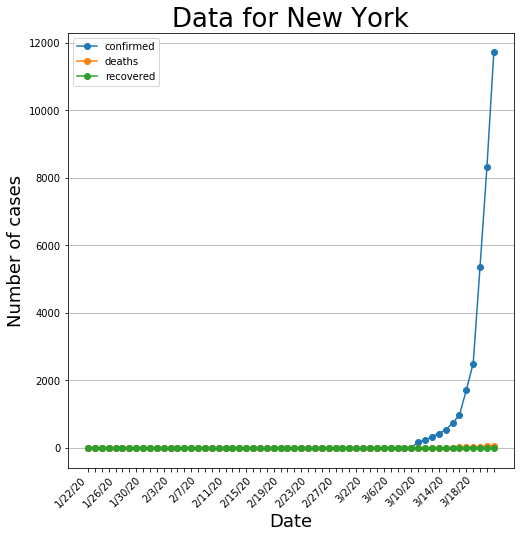

In [202]:
plotUSStateData('New York')

### Plot data with predictions for next n days

In [203]:
def getPredictionsForFuture_USState(USStateName,
                                    nDays=5,
                                    invertible=False, # Whether model is invertible or not
                                    plot=True,
                                    logScale=False,
                                    grid=None,
                                    printResults=True,
                                    tablesToUse='all',
                                    returnResults=False):
    '''
    tablesToUse is either 'all' for all tables, otherwise use a list containing one or more of 'confirmed', 'recovered' or 'deaths'
    '''
    
    # Extract model parameters
    p, d, q = (1, 2, 2)
    USStateCovidFrDict = getUSStateCovidFr(USStateName)
    plotStartedFlag = False
    if tablesToUse == 'all':
        keysList = countryCovidFrDict.keys()
    else:
        keysList = tablesToUse
    allData = {}
    predData = {}
    for key in keysList:
        if printResults:
            print('Table type:', key)
        data = list(USStateCovidFrDict[key][dateList].sum(axis=0))
        predictionsList = []

        for i in range(nDays):
            if invertible:
                model = SARIMAX(data, order=(p, d, q))

                model_fit = model.fit(disp=False)

                # make prediction
                yhat = model_fit.predict(len(data), len(data), typ='levels')
            else:
                model = SARIMAX(data, order=(p, d, q), enforce_invertibility=False)

                model_fit = model.fit(disp=False)

                # make prediction
                yhat = model_fit.predict(len(data), len(data), typ='levels')

            data.extend(yhat)
            predictionsList.append(yhat[0])
            
        # Required for printing as well as plotting
        dateTimeOjectForPlotList = dateTimeOjectList.copy()
        lastDateTimeObject = dateTimeOjectForPlotList[-1]
        futureDateTimeObjectList = []
        for i in range(nDays):
            lastDateTimeObject += timedelta(days=1)
            dateTimeOjectForPlotList.append(lastDateTimeObject)
            futureDateTimeObjectList.append(lastDateTimeObject)

        datetimeForPlotList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in dateTimeOjectForPlotList]
        futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]
        
        if printResults:
            print('Predictions for next {} days:'.format(nDays))
            # Round off predictions for printing
            predPrintList = [np.around(elem) for elem in predictionsList]
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
            print(tabulate(datePredList, headers=['Date', 'Prediction'], tablefmt='orgtbl'))
            
                
        if plot:
            # Start a plot if not already started
            if plotStartedFlag == False:
                fig = plt.figure(figsize=(8,8))
                ax = fig.add_subplot(111)
                plotStartedFlag = True
            if logScale:
                for i in range(len(data)):
                    if data[i] == 0:
                        data[i] = np.nan
            ax.plot(datetimeForPlotList, data, marker='o', label=key);
            # Circle predictions
            ax.scatter(futureDateTimeList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
        allDataDict = dict(zip(datetimeForPlotList, data))
        allData[key] = allDataDict

        predDict = dict(zip(futureDateTimeList, predictionsList))
        predData[key] = predDict
    if plot:
        if logScale:
            plt.yscale('log')
        plt.xticks(rotation=45, ha="right");
        
        every_nth = 4
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
        ax.legend(loc='upper left', prop={'size': 18});
        plt.title('Data for {}\n(Including predictions for next {} days)'.format(USStateName, nDays), fontsize=24);
        plt.xlabel('Date', fontsize=18);
        if logScale:
            plt.ylabel('Number of cases (log scale)', fontsize=18);
        else:
            plt.ylabel('Number of cases', fontsize=18);
        
        if grid != None:
            plt.grid(axis=grid)
        
    if returnResults:
        return allData, predData

Table type: confirmed
Predictions for next 5 days:
| Date     |   Prediction |
|----------+--------------|
| 03/22/20 |        15065 |
| 03/23/20 |        18176 |
| 03/24/20 |        21289 |
| 03/25/20 |        24403 |
| 03/26/20 |        27517 |


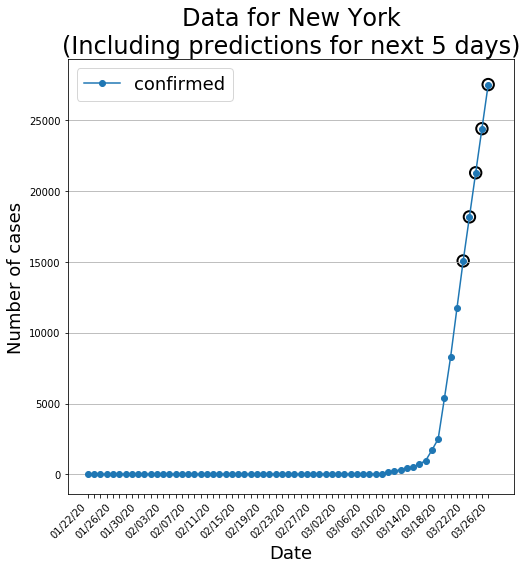

In [204]:
allData, predData = getPredictionsForFuture_USState('New York',
                                                    invertible=False,
                                                    plot=True,
                                                    logScale=False, 
                                                    printResults=True, 
                                                    nDays=5, 
                                                    tablesToUse=['confirmed'], 
                                                    grid='y',
                                                    returnResults=True)

### Interactive plot to select US state and other parameters

In [205]:
# Sort the list of US states for easier navigation
USStatesCorrectedList.sort()

# Generate a possible list of all combinations of tables
keysList = list(USCovidFrDict.keys())
tablesToUseList = []
for i in range(1,len(keysList)+1):
    tablesList = list(itertools.combinations(['confirmed', 'deaths', 'recovered'], i)) # This gives a tuple
    # Convert tuple to list
    tablesList = [list(tablesTuple) for tablesTuple in tablesList]
    # Extend this list
    tablesToUseList.extend(tablesList)

In [206]:
# Wrapper function to ignore certain parameters (such as returnResults and plot) in display
def getPredictionsForFuture_USStateWrapper(USStateName,
                                           nDays=5,
                                           invertible=False, # Whether model is invertible or not
                                           logScale=False,
                                           printResults=True,
                                           tablesToUse='all'):
    getPredictionsForFuture_USState(USStateName,
                                    nDays=nDays,
                                    invertible=invertible, # Whether model is invertible or not
                                    logScale=logScale,
                                    grid='y',
                                    printResults=printResults,
                                    tablesToUse=tablesToUse)
interact(getPredictionsForFuture_USStateWrapper,
         USStateName=USStatesCorrectedList,
         printResults=False,
         plot=True,
         grid='y',
         ndays=list(range(11)),
         invertible=False,
         tablesToUse=tablesToUseList,
         logScale=False,
         returnResults=False);

interactive(children=(Dropdown(description='USStateName', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas',…

### Compare plots of two or more states

In [207]:
def comparePlotsOfNUSStates(USStateNamesList,
                            nDays=5,
                            invertible=False, # Whether model is invertible or not
                            logScale=False,
                            grid=None,
                            printResults=True,
                            tableToUse='confirmed'):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    printListCreatedFlag = False
    for USStateName in USStateNamesList:
        allData, predData = getPredictionsForFuture_USState(USStateName,
                                                            nDays=nDays,
                                                            invertible=invertible,
                                                            plot=False,
                                                            logScale=logScale,
                                                            grid=grid,
                                                            printResults=False,
                                                            tablesToUse=[tableToUse],
                                                            returnResults=True)
        allData = allData[tableToUse]
        predData = predData[tableToUse]
        if logScale:
            for key in allData.keys():
                if allData[key] == 0:
                    allData[key] = np.nan
            
        ax.plot(list(allData.keys()), list(allData.values()), marker='o', label=USStateName);
        
        # Circle predictions
        ax.scatter(list(predData.keys()), list(predData.values()), s=130, linewidth=2, facecolors='none', edgecolors='k');
        
        if printListCreatedFlag == False:
            printListCreatedFlag = True
            
            futureDateTimeList = list(predData.keys())
            predictionsList = list(predData.values())
            predPrintList = [np.around(elem) for elem in predictionsList]
            
            # Zip dates and predictions together
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
        else:
            predictionsList = list(predData.values())
            for i in range(len(datePredList)):
                datePredList[i].append(np.around(predictionsList[i]))
            
    if printResults:
        headerList = ['Date']
        headerList.extend(USStateNamesList)
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
            
        
    plt.xticks(rotation=45, ha="right");
    if logScale:
        plt.yscale('log')
        
    every_nth = 4
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left', prop={'size': 18});
    
    plt.title('Data\n(Including predictions for next {} days)'.format(nDays), fontsize=24);
    plt.xlabel('Date', fontsize=18);
    if logScale:
        plt.ylabel('Number of cases (log scale)', fontsize=18);
    else:
        plt.ylabel('Number of cases', fontsize=18);
        
    if grid != None:
        plt.grid(axis=grid)

| Date     |   New York |   California |
|----------+------------+--------------|
| 03/22/20 |      15065 |         1571 |
| 03/23/20 |      18176 |         1771 |
| 03/24/20 |      21289 |         2010 |
| 03/25/20 |      24403 |         2265 |
| 03/26/20 |      27517 |         2535 |


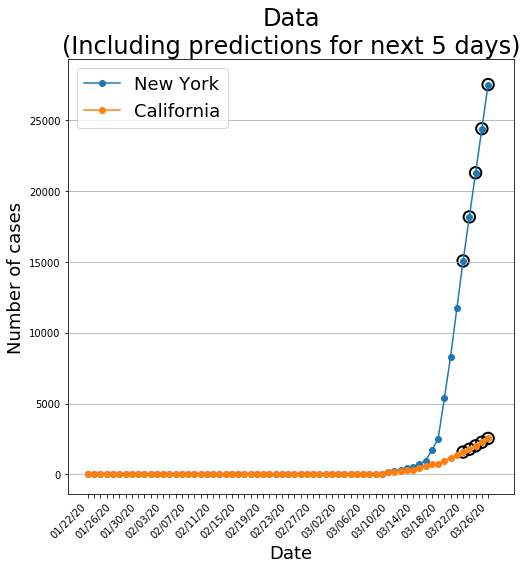

In [208]:
comparePlotsOfNUSStates(['New York', 'California'], nDays=5, grid='y', logScale=False)

In [209]:
# Interactive plot to compare data from 2 US states
def comparePlotsOf2USSTatesWrapper(USStateName1,
                                   USStateName2,
                                   nDays=5,
                                   invertible=True, # Whether model is invertible or not
                                   logScale=False,
                                   printResults=True,
                                   tableToUse='confirmed'):
    
    USStateNameList = [USStateName1, USStateName2]
    comparePlotsOfNUSStates(USStateNameList,
                            nDays=nDays,
                            invertible=invertible, # Whether model is invertible or not
                            logScale=logScale,
                            grid='y',
                            printResults=printResults,
                            tableToUse=tableToUse)
    plt.title('Data for {} and {}\n(Including predictions for next {} days)'.format(USStateName1,
                                                                                    USStateName2,
                                                                                    nDays),
              fontsize=24)
    
interact(comparePlotsOf2USSTatesWrapper,
         USStateName1=USStatesCorrectedList,
         USStateName2=USStatesCorrectedList,
         printResults=True,
         ndays=list(range(11)),
         invertible=False,
         tableToUse=keysList,
         logScale=False);

interactive(children=(Dropdown(description='USStateName1', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas'…

# Plot of new cases per day since n = 100th case

| Date     |   New York |   California |   Washington |
|----------+------------+--------------+--------------|
| 03/22/20 |       3946 |          225 |          233 |
| 03/23/20 |       4478 |          243 |          279 |
| 03/24/20 |       5013 |          263 |          297 |
| 03/25/20 |       5545 |          283 |          325 |
| 03/26/20 |       6078 |          303 |          351 |


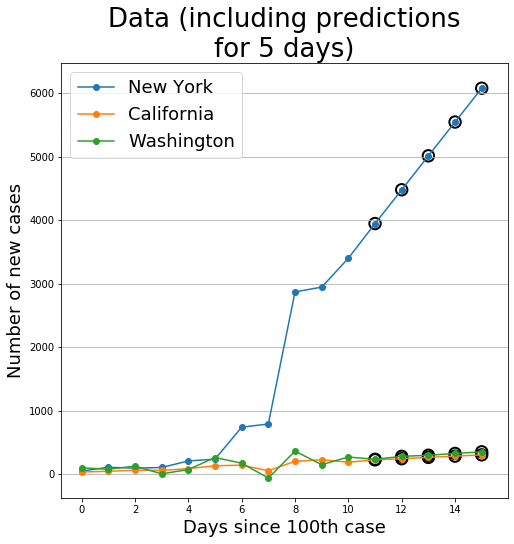

In [210]:
def comparePlotDaysSinceNCases_showNewCasesPerDay_USStates(USStateNamesList,
                                                           logScale=False,
                                                           daysSince=100,
                                                           invertible=False,
                                                           nDaysPrediction=5,
                                                           timeSeriesLim = 40, # Limit size of data to 40 points only
                                                           printResults=True):
    p, d, q = (1, 2, 2)
    plotStartedFlag = False
    printListCreatedFlag = False
    for USStateName in USStateNamesList:
        allData, predData = getPredictionsForFuture_USState(USStateName,
                                                            nDays=0,
                                                            invertible=False, # Whether model is invertible or not
                                                            plot=False,
                                                            logScale=False,
                                                            grid=None,
                                                            printResults=False,
                                                            tablesToUse=['confirmed'],
                                                            returnResults=True)
        USStateConfirmedFr =  allData['confirmed']
        
        nCasesGreaterDaysSinceList = []
        datesGreaterDaysSinceList = []
        for key in USStateConfirmedFr.keys():
            if USStateConfirmedFr[key] > daysSince:
                datesGreaterDaysSinceList.append(key)
                nCasesGreaterDaysSinceList.append(USStateConfirmedFr[key])
                
        casesPerDayList = [t - s for s, t in zip(nCasesGreaterDaysSinceList, nCasesGreaterDaysSinceList[1:])]
        
        lastDateAvailable = datesGreaterDaysSinceList[-1]
        lastDateAvailableDateTimeObject = datetime.strptime(lastDateAvailable, '%m/%d/%y')
        
        data = casesPerDayList
        if len(data) > timeSeriesLim:
            data = data[:timeSeriesLim+1]
        predictionsList = []
        predictionPointsXCoordinateList = list(range(len(data), len(data)+nDaysPrediction))

        for i in range(nDaysPrediction):
            model = SARIMAX(data, order=(p, d, q), enforce_invertibility=invertible)

            model_fit = model.fit(disp=False)

            # make prediction
            yhat = model_fit.predict(len(data), len(data), typ='levels')

            data.extend(yhat)
            predictionsList.append(yhat[0])

        if printListCreatedFlag == False:
            printListCreatedFlag = True

            futureDateTimeObjectList = []
            for i in range(nDaysPrediction):
                lastDateAvailableDateTimeObject += timedelta(days=1)
                futureDateTimeObjectList.append(lastDateAvailableDateTimeObject)
            futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]

            predPrintList = [np.around(elem) for elem in predictionsList]

            # Zip dates and predictions together
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
        else:
            for i in range(len(datePredList)):
                datePredList[i].append(np.around(predictionsList[i]))
        
        if plotStartedFlag == False:
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            plotStartedFlag = True
        if logScale:
            for i in range(len(data)):
                if data[i] == 0:
                    data[i] = np.nan
        ax.plot(data, marker='o', label=USStateName);
        

        # Circle predictions
        ax.scatter(predictionPointsXCoordinateList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
    if printResults:
        
        headerList = ['Date']
        for USStateName in USStateNamesList:
            headerList.append(USStateName)
                
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
        
    ax.legend(loc='upper left', prop={'size': 18});
#     plt.title('Data for {}'.format(countryName), fontsize=26);
    plt.title('Data (including predictions\nfor {} days)'.format(nDaysPrediction), fontsize=26);
    plt.xlabel('Days since {}th case'.format(daysSince), fontsize=18);
    plt.ylabel('Number of new cases', fontsize=18);
    plt.grid(axis='y')
        
comparePlotDaysSinceNCases_showNewCasesPerDay_USStates(['New York', 'California', 'Washington'], daysSince=100)